In [17]:
import os
import torch
import torchvision
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [18]:
# case can have to be mix of this two groops (rgb, dept, Ergbd, Lrgbd) and (rad, angle)

case = 'Ergbd_rad'
ver = 0

In [19]:
def circular_loss(predictions, targets):
    
    diff = torch.abs(predictions - targets)
    circular_diff = torch.min(diff, 360.0 - diff)
    loss = torch.mean(circular_diff)
    
    penalty = torch.mean(torch.abs(predictions - torch.clamp(predictions, 0, 360)))
    
    total_loss = loss + penalty
    
    return total_loss 

In [20]:
class LateFusionNet(torch.nn.Module):
    def __init__(self):
        super(LateFusionNet, self).__init__()
        # Separate convolutional layers for RGB and depth streams
        self.conv_rgb = torchvision.models.resnet18(pretrained=False)
        self.conv_rgb.fc = torch.nn.Identity()
        
        self.conv_depth = torchvision.models.resnet18(pretrained=False)
        self.conv_depth.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv_depth.fc = torch.nn.Identity()
        
        # Fully connected layers for fusion
        self.fc1 = torch.nn.Linear(512 * 2, 128)  # Concatenating features from both streams
        self.fc2 = torch.nn.Linear(128, 1)  # Adjust num_classes based on your task
        
    def forward(self, rgbd_inputs):
        rgb_inputs = rgbd_inputs[:,:3,:,:]
        depth_inputs = rgbd_inputs[:,3,:,:].unsqueeze(1)

        # Forward pass for RGB stream
        rgb_features = self.conv_rgb(rgb_inputs)
        # Forward pass for depth stream
        depth_features = self.conv_depth(depth_inputs)
        
        # Concatenate features from both streams
        combined_features = torch.cat((rgb_features, depth_features), dim=1)
        
        # Fully connected layers for fusion
        x = self.fc1(combined_features)
        x = torch.relu(x)
        x = self.fc2(x)
        return x


In [21]:
class rgbd_dataset(torch.utils.data.Dataset):
    def __init__(self, rgb_dataset, depth_dataset, transform=None):
        self.rgb_dataset = rgb_dataset
        self.depth_dataset = depth_dataset
        self.transform = transform

    def __len__(self):
        return len(self.rgb_dataset)

    def __getitem__(self, idx):
        rgb_img, rgb_label = self.rgb_dataset[idx]
        depth_img, _ = self.depth_dataset[idx]

        # Convert depth image to single-channel grayscale
        depth_img = torch.mean(depth_img, dim=0, keepdim=True)

        # Concatenate RGB and depth images along the channel dimension
        rgbd_img = torch.cat([rgb_img, depth_img], dim=0)

        # Apply transformations if provided
        if self.transform:
            rgbd_img = self.transform(rgbd_img)

        # Return the rgbd_img and the label from the RGB image
        return rgbd_img, rgb_label

In [22]:
class ImageRegressionDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = os.listdir(data_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(image_name)

        target = float(os.path.splitext(self.image_files[idx])[0])

        if self.transform:
            image = self.transform(image)
            target = torch.tensor(target).unsqueeze(0)

        return image, target

In [23]:
if case.split('_')[1] == 'angle':
    rgb_data_dir = './dataset/train/angle/rgb'
    depth_data_dir = './dataset/train/angle/depth'
    
elif case.split('_')[1] == 'rad':
    rgb_data_dir = './dataset/train/rad/rgb'
    depth_data_dir = './dataset/train/rad/depth'

In [24]:
model = torchvision.models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(512, 1)

if case.split('_')[0] == 'depth':
    model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# elif case.split('_')[0] == 'rgb':
  # model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    
elif case.split('_')[0] == 'Ergbd':
    model.conv1 = torch.nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

elif case.split('_')[0] == 'Lrgbd':
    model = LateFusionNet()

model.eval()

ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
rgb_train_transfor = transforms.Compose([transforms.ToTensor(),
                                        transforms.ColorJitter(brightness=.5, hue=.1, saturation=[0.5, 1.5], contrast=[0.5, 1.5]),
                                        ])
rgb_val_transform = transforms.Compose([transforms.ToTensor(),
                                                    ])
depth_train_transfor = transforms.Compose([transforms.ToTensor(),
                                        transforms.Grayscale(num_output_channels=1),
                                      ])    
depth_val_transform = transforms.Compose([transforms.ToTensor(), 
                                                    transforms.Grayscale(num_output_channels=1),
                                                    ])

RandomCrop_transform = transforms.Compose([transforms.RandomCrop(240, padding=25)])

rgb_ds_train = ImageRegressionDataset(rgb_data_dir, transform=rgb_train_transfor)
depth_ds_train = ImageRegressionDataset(depth_data_dir, transform=depth_train_transfor)

rgb_ds = ImageRegressionDataset(rgb_data_dir, transform=rgb_val_transform)
depth_ds = ImageRegressionDataset(depth_data_dir, transform=depth_val_transform)

train_size = int(0.9 * len(rgb_ds))
val_size = len(rgb_ds) - train_size

rgb_train_ds, rgb_val_ds = torch.utils.data.random_split(rgb_ds, [train_size, val_size])
depth_train_ds = torch.utils.data.Subset(depth_ds, rgb_train_ds.indices)
depth_val_ds = torch.utils.data.Subset(depth_ds, rgb_val_ds.indices)

rgb_train_ds.dataset = rgb_ds_train
depth_train_ds.dataset = depth_ds_train

if case.split('_')[0] == 'rgb':
  train_ds = rgb_train_ds
  val_ds = rgb_val_ds
  train_ds.dataset.transform = transforms.Compose([train_ds.dataset.transform, RandomCrop_transform]) 
     
if case.split('_')[0] == 'depth':
  train_ds = depth_train_ds
  val_ds = depth_val_ds
  train_ds.dataset.transform = transforms.Compose([train_ds.dataset.transform, RandomCrop_transform])
      
elif 'rgbd' in case.split('_')[0]:
  train_ds = rgbd_dataset(rgb_train_ds, depth_train_ds, RandomCrop_transform)
  val_ds = rgbd_dataset(rgb_val_ds, depth_val_ds)
  

In [26]:
def evaluate(model, dataloader, device, loss_fn):
    model.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

    average_loss = total_loss / len(dataloader)
    
    return average_loss

def fit(epochs, model, train_dl, val_dl, device, opt, loss_fn):
    
    scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=3, verbose=True)
    best_val_loss = 9999999999
    best_model_state = None
    
    for epoch in range(epochs):
        model.train() 
        train_loss = 0.0
                
        for data in train_dl:
            inputs, labels = data # get the inputs
            inputs = inputs.to(device) # send them to device
            labels = labels.to(device) # forward + backward + optimize
            outputs = model(inputs) # forward pass
            loss = loss_fn(outputs, labels) # calculate the loss
            opt.zero_grad() # zero the parameter gradients
            loss.backward() # backpropagation
            opt.step() # update parameters
            train_loss += loss.item() # accumulate loss
            
        train_loss /= len(train_dl)
        val_loss = evaluate(model, val_dl, device, loss_fn)

        log = "Epoch: {} | Training Loss: {:.4f} | Validation Loss: {:.4f}".format(epoch+1, train_loss, val_loss)
        print(log)
           
        if val_loss  < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            print(f'model saved.')
        
        scheduler.step(val_loss)
        
    return (best_model_state)

In [27]:
# hyper-parameters
batch_size = 64
lr = 1e-4
epochs = 25
# dataloaders - creating batches and shuffling the data
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl  = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
# device - cpu or gpu?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')
# loss criterion
opt = torch.optim.Adam(model.parameters(), lr=lr)
if case.split('_')[1] == 'angle':
    loss_fn = circular_loss
else:
    loss_fn = torch.nn.MSELoss()

# build our model and send it to the device
model.to(device) # no need for parameters as we alredy defined them in the class

Using cuda:0


ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
def show_batch(dl, case):
    if 'rgbd' in case.split('_')[0]:
        for images, _ in dl:
            fig, ax = plt.subplots(figsize=(20,20))
            ax.set_xticks([]); ax.set_yticks([])
            ax.set_facecolor('white')

            rgb_imgs = images[:,:3,:,:]
            depth_imgs = images[:,3,:,:].unsqueeze(1)
            depth_imgs = depth_imgs.repeat(1, 3, 1, 1)

            rgbd_imgs = []
            for i in range(0, len(rgb_imgs), 2):
                rgbd_imgs.append(rgb_imgs[i])
                rgbd_imgs.append(depth_imgs[i])
                
            ax.imshow(make_grid(rgbd_imgs,10).permute(1,2,0))
            break
    else:
        for images, _ in dl:
            fig, ax = plt.subplots(figsize=(20,20))
            ax.set_xticks([]); ax.set_yticks([])
            ax.imshow(make_grid(images,10).permute(1,2,0))
            break

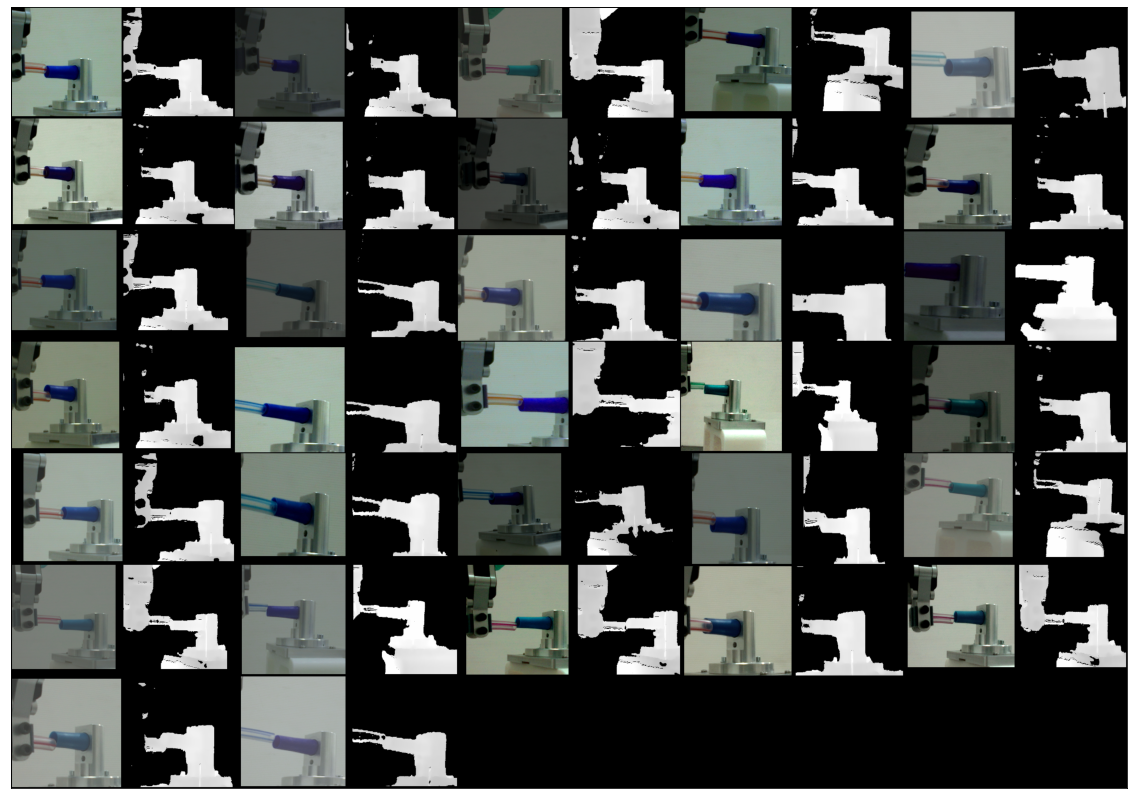

In [29]:
show_batch(train_dl, case)

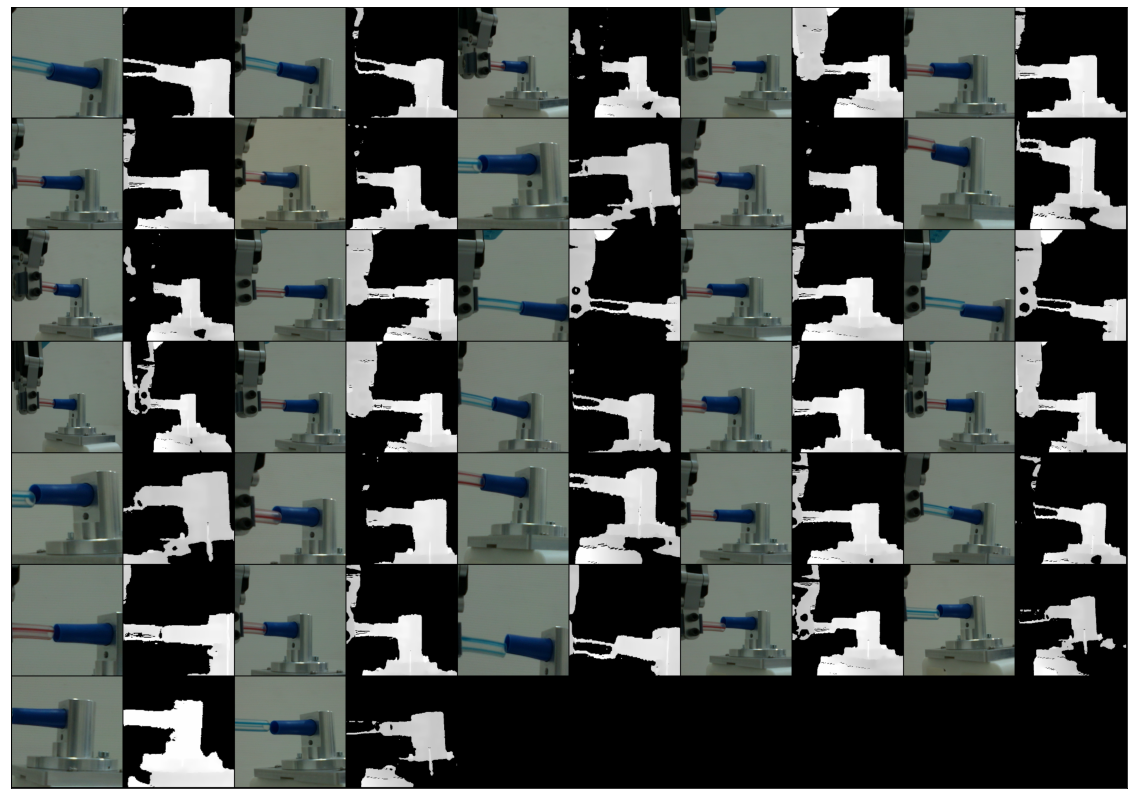

In [30]:
show_batch(val_dl, case)

In [31]:
best_model = fit(epochs, model, train_dl, val_dl, device, opt, loss_fn)

Epoch: 1 | Training Loss: 3.5625 | Validation Loss: 3.1906
model saved.
Epoch: 2 | Training Loss: 2.7728 | Validation Loss: 3.1871
model saved.
Epoch: 3 | Training Loss: 1.9437 | Validation Loss: 3.2197
Epoch: 4 | Training Loss: 1.4724 | Validation Loss: 2.0060
model saved.
Epoch: 5 | Training Loss: 1.2651 | Validation Loss: 1.2916
model saved.
Epoch: 6 | Training Loss: 1.1511 | Validation Loss: 1.2958
Epoch: 7 | Training Loss: 1.0028 | Validation Loss: 1.1190
model saved.
Epoch: 8 | Training Loss: 0.9405 | Validation Loss: 1.0375
model saved.
Epoch: 9 | Training Loss: 0.8647 | Validation Loss: 0.9020
model saved.
Epoch: 10 | Training Loss: 0.7580 | Validation Loss: 1.5047
Epoch: 11 | Training Loss: 0.7396 | Validation Loss: 1.2209
Epoch: 12 | Training Loss: 0.6688 | Validation Loss: 1.0656
Epoch: 13 | Training Loss: 0.6187 | Validation Loss: 0.8737
model saved.
Epoch: 14 | Training Loss: 0.5593 | Validation Loss: 0.6587
model saved.
Epoch: 15 | Training Loss: 0.5257 | Validation Loss:

In [32]:
save_path = './Weights/' + case + '_v' + str(ver) + '.pth'

torch.save(best_model, save_path)